In [8]:
# https://ai.plainenglish.io/googlenet-inceptionv1-with-tensorflow-9e7f3a161e87

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model

In [10]:
(x_train,y_train),(x_test,y_test) = datasets.mnist.load_data()
x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)
x_val = x_train[-2000:,:,:,:]
y_val = y_train[-2000:]
x_train = x_train[:-2000,:,:,:]
y_train = y_train[:-2000]

In [11]:
def inception(x,
              filters_1x1,
              filters_3x3_reduce,
              filters_3x3,
              filters_5x5_reduce,
              filters_5x5,
              filters_pool):
    path1 = layers.Conv2D(filters_1x1, (1, 1), padding='same',    activation='relu')(x)
    path2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    path2 = layers.Conv2D(filters_3x3, (1, 1), padding='same', activation='relu')(path2)
    path3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    path3 = layers.Conv2D(filters_5x5, (1, 1), padding='same', activation='relu')(path3)
    path4 = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(path4)
    return tf.concat([path1, path2, path3, path4], axis=3)

In [12]:
inp = layers.Input(shape=(32, 32, 3))
input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train.shape[1:])(inp)

x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(input_tensor)
x = layers.MaxPooling2D(3, strides=2)(x)
x = layers.Conv2D(64, 1, strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, 3, strides=1, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(3, strides=2)(x)
x = inception(x, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool=32)
x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool=64)
x = layers.MaxPooling2D(3, strides=2)(x)
x = inception(x, filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool=64)

aux1 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux1 =layers.Conv2D(128, 1, padding='same', activation='relu')(aux1)
aux1 = layers.Flatten()(aux1)
aux1 = layers.Dense(1024, activation='relu')(aux1)
aux1 = layers.Dropout(0.7)(aux1)
aux1 = layers.Dense(10, activation='softmax')(aux1)

x = inception(x, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
x = inception(x, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool=64)

aux2 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux2 =layers.Conv2D(128, 1, padding='same', activation='relu')(aux2)
aux2 = layers.Flatten()(aux2)
aux2 = layers.Dense(1024, activation='relu')(aux2)
aux2 = layers.Dropout(0.7)(aux2) 
aux2 = layers.Dense(10, activation='softmax')(aux2)

x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
x = layers.MaxPooling2D(3, strides=2)(x)
x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
x = inception(x, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool=128)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)

out = layers.Dense(10, activation='softmax')(x)

In [13]:
model = Model(inputs = inp, outputs = [out, aux1, aux2])

In [14]:
model.compile(optimizer='adam', 
            #   loss=[losses.sparse_categorical_crossentropy,
            #         losses.sparse_categorical_crossentropy,
            #         losses.sparse_categorical_crossentropy]
            loss='sparse_categorical_crossentropy',
            loss_weights=[1, 0.3, 0.3],
            metrics=['accuracy'])
history = model.fit(x_train, [y_train, y_train, y_train], validation_data=(x_val, [y_val, y_val, y_val]), batch_size=200, epochs=40)

Epoch 1/40
290/290 [==============================] - 4103s 14s/step - loss: 1.6651 - dense_9_loss: 1.2581 - dense_6_loss: 0.6288 - dense_8_loss: 0.7279 - dense_9_accuracy: 0.5397 - dense_6_accuracy: 0.7860 - dense_8_accuracy: 0.7539 - val_loss: 0.4399 - val_dense_9_loss: 0.3679 - val_dense_6_loss: 0.1005 - val_dense_8_loss: 0.1398 - val_dense_9_accuracy: 0.9035 - val_dense_6_accuracy: 0.9665 - val_dense_8_accuracy: 0.9600
Epoch 2/40
290/290 [==============================] - 4208s 15s/step - loss: 0.3266 - dense_9_loss: 0.2445 - dense_6_loss: 0.1278 - dense_8_loss: 0.1459 - dense_9_accuracy: 0.9275 - dense_6_accuracy: 0.9603 - dense_8_accuracy: 0.9553 - val_loss: 0.1738 - val_dense_9_loss: 0.1298 - val_dense_6_loss: 0.0727 - val_dense_8_loss: 0.0738 - val_dense_9_accuracy: 0.9650 - val_dense_6_accuracy: 0.9810 - val_dense_8_accuracy: 0.9795
Epoch 3/40
290/290 [==============================] - 3994s 14s/step - loss: 0.1730 - dense_9_loss: 0.1201 - dense_6_loss: 0.0854 - dense_8_loss: 

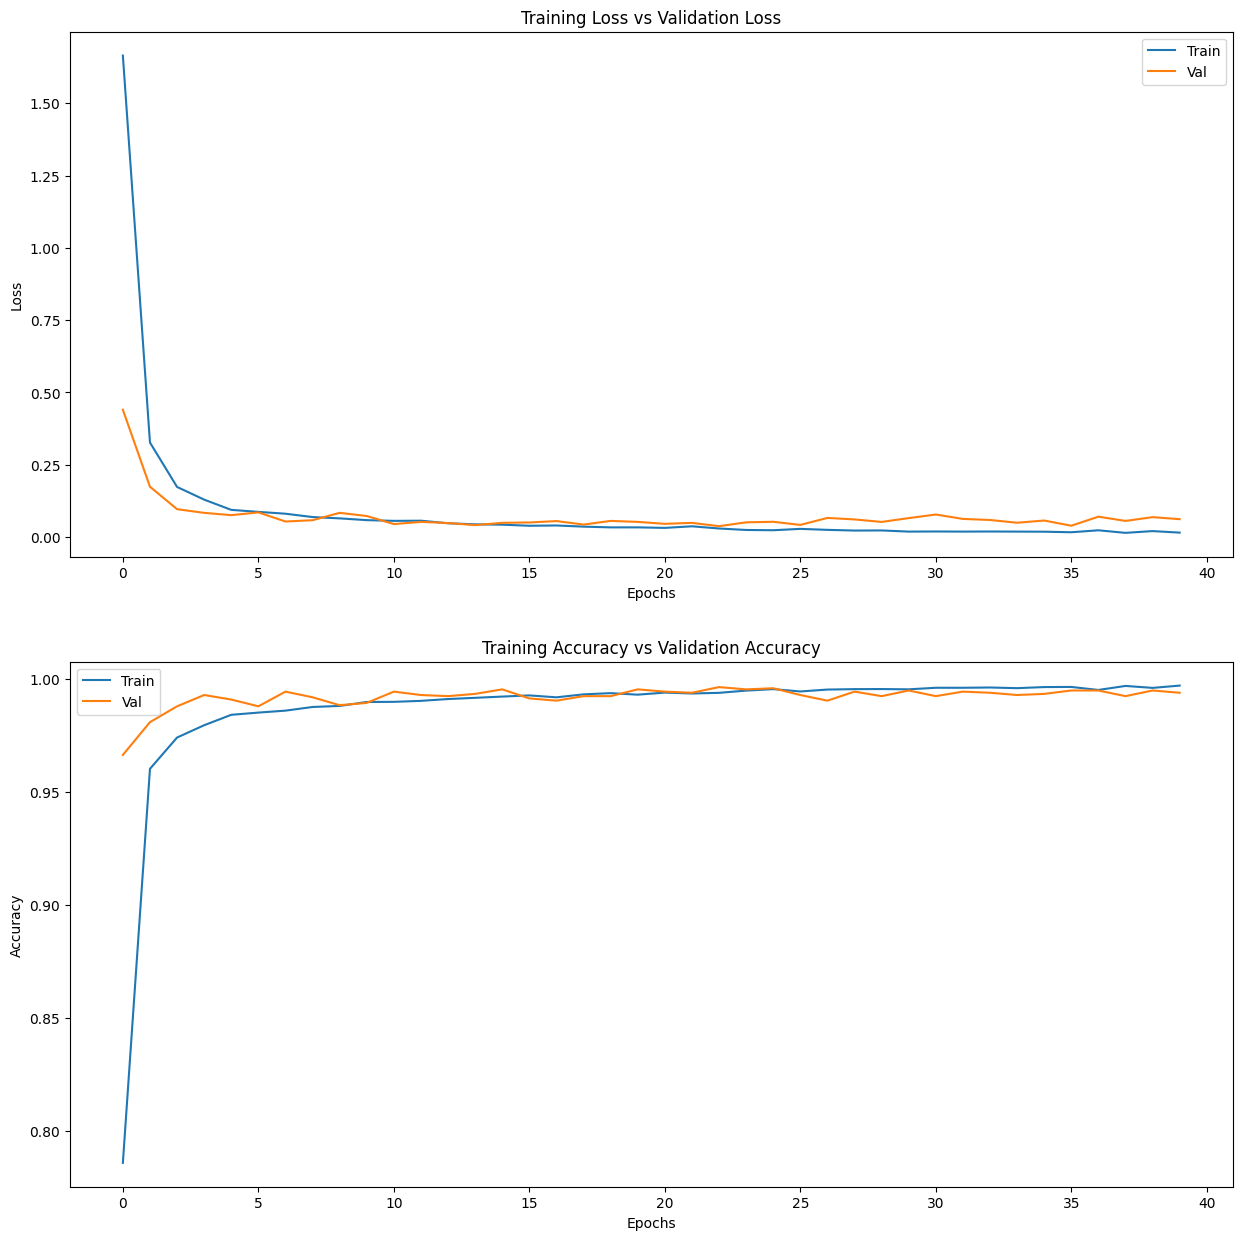

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['dense_6_accuracy'])
axs[1].plot(history.history['val_dense_6_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [21]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 126s 399ms/step - loss: 0.0394 - dense_9_loss: 0.0249 - dense_6_loss: 0.0229 - dense_8_loss: 0.0255 - dense_9_accuracy: 0.9937 - dense_6_accuracy: 0.9933 - dense_8_accuracy: 0.9943


[0.03937708958983421,
 0.02485579624772072,
 0.022888902574777603,
 0.025515476241707802,
 0.9937000274658203,
 0.9933000206947327,
 0.9943000078201294]